In [1]:
import pandas as pd
import spacy
from spacy import displacy
import re
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

NER = spacy.load("en_core_web_sm")

# Step 1. Extract hard-skills

First, load the dataframe, and prepare it a little bit (We do not lowercase or delete punctuation signs because it can interfere with the model I am to use later)

In [2]:
def prepare_df(df, cols_to_keep=['title', 'company', 'description', 'position']):
    new_df=df[cols_to_keep]
    return new_df

In [3]:
df=prepare_df(pd.read_csv('merged_4k.csv'))

## NER MODEL

For extracting hard skills we use NER model from spacy. 
This model recognizes named entities such as companies, people, dates and so on.

The model identifies some skills but also identifies a lot of things which are not skills. Thus, we shall apply the model along with a couple of restrictions:
- Stop words. I've identified some words which do not appear in the name of the skills but are identified as ORG by NER. So I do not include entitites containing these words.
- Uppercasing. Technical skills are the names of the programs (like Python, Java, etc) so we only keep entities which begin with the uppercase.
- We also exclude the company name from the description, because this is not a skill.

**Such moves will reduce the amount of skills extracted and we may potentially miss a lot of skills. However, this is a tolerable limitation for the 1st step, because for now, we just need to have at least some skills.**

In [14]:
stops=['group', 'ontario', 'canada', 'rights', 'salary', 'company', 'operation', 'inc.', 'co-op', 'internship', 'startup', 'job', 'career', 'friday']

In [15]:
def hard_skills(descr, compName):
    name=compName.lower()
    info=NER(descr)
    raw_skills=[]
    for ent in info.ents:
        if ent.text[0].isupper():
            extracted=ent.text.lower()
            if (ent.label_=='ORG' or ent.label=='PERSON') and extracted not in name and name not in extracted and not any(stop in extracted for stop in stops):
                raw_skills.append(extracted)
    ready_skills=[]
    for skill in raw_skills:
        splitted=re.split('[&,|/]', skill)
        for true_skill in splitted:
            if true_skill not in ready_skills:
                ready_skills.append(true_skill)
    return ready_skills

In [16]:
def add_hard_skills(df):
    hs=[]
    for row in df.itertuples(index=False):
        hs.append(hard_skills(row.description, row.company))
    new_df=df
    new_df['hard_skills']=hs
    return new_df

In [17]:
df_hard=add_hard_skills(df)
df_hard.head(5)

,title,company,description,position,hard_skills
0,University Grad Software Engineer (Canada),Pinterest,About Pinterest:\nMillions of people across th...,developer,[pinployees]
1,Administration (1) - RPG AS400 Developer,Zwilling J.A. Henckels Canada Ltd,About ZWILLING J.A. Henckels:\nFor over 285 ye...,developer,"[demeyere (belgium, rpg, developer (contract p..."
2,Senior Web Developer - Full Stack/Backend,WorkTango,WorkTango was founded as a passion-driven busi...,developer,"[devops, gitlab\nbusiness]"
3,React + Ruby on Rails Developer - Remote - Canada,FullStack Labs,FullStack Labs is the fastest-growing software...,developer,"[uber, godaddy, mgm, siemens, stanford univer..."
4,newSenior Back End Developer,BIMM,"BIMM is booming, so we’re looking for a Senior...",developer,"[devops, php, nginx]"


## Skill's visualization

In [18]:
skills_arr=np.array(df['hard_skills'])
skills_arr

array([list(['pinployees']),
       list(['demeyere (belgium', 'rpg', 'developer (contract position', 'ibm', 'erp', 'continual learning', 'dependability\nresearch and analysis', 'edi', 'a', 'r ', ' a', 'p', 'ssh', 'ftp', 'tm1']),
       list(['devops', 'gitlab\nbusiness']), ...,
       list(['maven', 'jpa', 'hibernate', 'redis', 'junit', 'testng', ' readyapi)', 'javascript', 'ai']),
       list(['typescriptbuilding', 'chrome', 'react suspense and hooks', 'assembly', 'workerswork', 'webpack', ' jest', 'android', 'highcharts and material uibs']),
       list(['building envelope', 'p', 'l', 'building materials management'])],
      dtype=object)

In [19]:
def flat_2d_arr(arr):
    flat=[]
    for small in arr:
        for element in small:
            flat.append(element)
    return flat

In [20]:
skills_arr=flat_2d_arr(skills_arr)

#### The word cloud shows the most frequent words in the array of skills. We've been editing 'stops' until we've became satisfied with the results.

In [21]:
cnt = Counter() # Method for calculating occurences is taken from: https://stackoverflow.com/questions/4088265/sorted-word-frequency-count-using-python
for skill in skills_arr:
    cnt[skill] += 1
cnt

Counter({'pinployees': 1,
         'demeyere (belgium': 1,
         'rpg': 1,
         'developer (contract position': 1,
         'ibm': 50,
         'erp': 73,
         'continual learning': 1,
         'dependability\nresearch and analysis': 1,
         'edi': 26,
         'a': 4,
         'r ': 1,
         ' a': 1,
         'p': 66,
         'ssh': 3,
         'ftp': 20,
         'tm1': 1,
         'devops': 445,
         'gitlab\nbusiness': 1,
         'uber': 3,
         ' godaddy': 3,
         'mgm': 3,
         'siemens': 28,
         'stanford university': 28,
         'glassdoor': 25,
         'paid time off': 3,
         'english classes': 3,
         'php': 123,
         'nginx': 29,
         'contractors and permanent': 1,
         'banking': 1,
         ' capital markets': 1,
         'finance risk ': 1,
         ' compliance': 6,
         'wealth and investment management': 1,
         'digital': 41,
         'ci': 277,
         'java restful': 1,
         'platform': 5,

In [22]:
sorted_freq_skills=cnt.most_common()
sorted_freq_skills

[('devops', 445),
 ('sql', 405),
 ('javascript', 375),
 ('css', 323),
 ('ci', 277),
 ('rest', 260),
 ('microsoft', 255),
 ('computer science', 234),
 ('ui', 226),
 ('dental', 214),
 ('microsoft office', 195),
 ('mvc', 172),
 ('android', 166),
 ('agile', 159),
 ('', 156),
 ('powerpoint', 136),
 ('human resources', 130),
 ('ai', 127),
 ('php', 123),
 ('gta', 113),
 ('project management', 111),
 ('terraform', 110),
 ('ms office', 109),
 ('redis', 108),
 ('powershell', 104),
 ('spark', 96),
 ('software engineering', 95),
 ('html5', 95),
 ('github', 94),
 ('bitbucket', 94),
 ('kpi', 93),
 ('java', 93),
 ('ux', 86),
 ('big data', 85),
 ('ms', 83),
 ('software development', 82),
 ('rrsp', 81),
 ('etl', 81),
 ('oversee', 81),
 ('api', 80),
 ('python', 79),
 ('mvvm', 77),
 ('isarta.com', 75),
 ('erp', 73),
 ('skills', 71),
 ('hadoop', 71),
 ('graphql', 70),
 ('linux', 69),
 ('http', 68),
 ('skills ', 68),
 ('software', 67),
 ('data', 67),
 ('information technology', 67),
 ('p', 66),
 ('junit', 

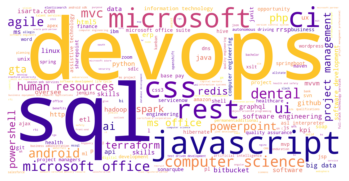

In [30]:
wordcloud = WordCloud(colormap='plasma', background_color='white', width=1600, height=800).generate_from_frequencies(cnt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('words_4k_hard.png', bbox_inches='tight')
plt.show()

In [34]:
with open('my.svg', 'w') as f:
    f.write(wordcloud.to_svg())

Now, let's turn our skills into a set to delete repetitions.

In [35]:
set_skills=set(skills_arr)
set_skills

{'',
 ' batch service',
 'yesexperience',
 'ctv news',
 'wcb',
 'my school handbook',
 'devops',
 'puppet',
 'massachusetts institute of technology',
 'cli',
 'virtualbox',
 'dpm',
 'capm',
 'cross-functional',
 'osha acts',
 'qualifications ',
 'product',
 'c insurance',
 'data warehousing',
 'pcftools',
 'mvp',
 'active directory',
 'siebel developer - assignment start date',
 'guest',
 'pq',
 ' communications department',
 ' financial management reporting',
 ' azure db',
 'multi-factor auth·',
 'de-bugging ',
 'requiredyou',
 ' responsibilities**manager',
 'effortsricoh',
 'brampton',
 'accounts payable',
 'ms office (project',
 'value engineering',
 'd-camps',
 'dvi',
 'gauge',
 'on\neducation-',
 'ssl pinning',
 'webtrends',
 'oil and gas',
 'traditional trade',
 'easytrievebanking',
 ' gr',
 'npmcontract',
 'dig',
 ' stake holders (owners',
 'parental ',
 'oracle gold partner',
 'mocha',
 'fda',
 'boss2',
 'application development technical lead',
 'data models',
 'etf',
 'accoun

Now, let's delete empty entries and trailing whitespaces from the set

In [36]:
better_skills={x.strip() for x in set_skills if (x!='' and (len(x)>1 or x=='r'))}
better_skills

{'',
 'yesexperience',
 'ctv news',
 'wcb',
 'my school handbook',
 'kitchen',
 'devops',
 'puppet',
 'massachusetts institute of technology',
 'mining and infrastructure',
 'absolute',
 'emotional intelligencetransformative thinking',
 'cli',
 'buildings',
 'virtualbox',
 'dpm',
 'capm',
 'osha acts',
 'cross-functional',
 'product',
 'c insurance',
 'excel',
 'data warehousing',
 'pcftools',
 'mvp',
 'active directory',
 'siebel developer - assignment start date',
 'federation services',
 'guest',
 'pq',
 'system definition',
 'multi-factor auth·',
 'requiredyou',
 'effortsricoh',
 'brampton',
 'accounts payable',
 'ms office (project',
 'value engineering',
 'd-camps',
 'dvi',
 'stake holders (owners',
 'gauge',
 'pmi-acp',
 'on\neducation-',
 'ssl pinning',
 'webtrends',
 'oil and gas',
 'traditional trade',
 'easytrievebanking',
 'oracle aia',
 'npmcontract',
 'dig',
 'reserve and innovation',
 'oracle gold partner',
 'mocha',
 'fda',
 'boss2',
 'application development technical 

Now, perform the same preprocessing for skills in our df

In [37]:
def basic_prepr_skills(df, col_skills):
    result=[]
    skills_2d=np.array(df[col_skills])
    for ent in skills_2d:
        prepr=[x.strip() for x in ent if (x!='' and (len(x)>1 or x=='r'))]
        result.append(prepr)
    new_df=df
    new_df[col_skills]=result
    return new_df

In [38]:
df_hard_prepr=basic_prepr_skills(df, 'hard_skills')

# STEP 2: Analyze the grammar structure

Now, let's analyze the role our identified skills play in the sentences. We do this by using Spacy linguistic tools. 
We want to know:
    - which part of speech each skill is (for skills made of a couple of words, treat each word as a skill, just for the purposes of this step)
    - how the word is related to the other words in the sentence

What we want to know:
- Are there any POS tags which are present in skills more frequently than in other words?
- Are there any roles which are present in skills more grequently than in words?
- Same questions for skills heads
**Note: head here means the word the skill is dependent on*
- What are the words contained in the skills heads?

In [39]:
simple_pos_all=[]
role_all=[]
simple_pos_skills=[]
role_skills=[]
head_skill_simple_pos=[]
head_skill_role=[]
head_text=[]
head_head_text=[]
all_descs=list(df['description'])
for desc in all_descs:
    nlp_desc=NER(desc.lower()) #Can lowercase everything now, because it won't affect the model
    for token in nlp_desc:
        simple=token.pos_
        role=token.dep_
        head_simple=token.head.pos_
        head_role=token.head.dep_
        ht=token.head.text
        hht=token.head.head.text
        if token.is_stop==False and token.pos_ not in['PUNCT', 'SPACE', 'AUX']:
            simple_pos_all.append(simple)
            role_all.append(role)
            if any(token.text in skill for skill in better_skills):
                simple_pos_skills.append(simple)
                role_skills.append(role)
                if token.head.is_stop==False and token.head.pos_ not in ['PUNCT', 'SPACE', 'AUX']:
                    head_skill_simple_pos.append(head_simple)
                    head_skill_role.append(head_role)
                    head_text.append(ht)
                if token.head.head.is_stop==False and token.head.head.pos_ not in ['PUNCT', 'SPACE', 'AUX']:
                    head_head_text.append(hht)
        

In [40]:
def calc_occ(arr):
    cnt=Counter()
    for word in arr:
        cnt[word]+=1
    return cnt

In [57]:
def gen_wordCloud(arr):
    wordcloud = WordCloud(colormap='plasma', background_color='white', width=900, height=400).generate_from_frequencies(calc_occ(arr))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return wordcloud

In [42]:
def gen_stack(arrs, colnames, gen='freq', ret=False, my_title=''):
    cnts=[]
    for arr in arrs:
        cnts.append(calc_occ(arr))
    dfs=[]
    for i in range (0, len(cnts)):
        df=pd.DataFrame(cnts[i].most_common(), columns=['LABEL', colnames[i]]).set_index('LABEL')
        dfs.append(df)
    final_df=dfs[0]
    for d in range (1, len(dfs)):
        final_df=pd.merge(final_df, dfs[d], on='LABEL')
    sums=[]
    for c in range (0, len(colnames)):
        summing=final_df[colnames[c]].sum()
        sums.append(summing)
    new_df=final_df
    freq_names=[]
    for f in range (0, len(sums)):
        name=colnames[f]+'_freq'
        freq_names.append(name)
        new_df[name]=new_df[colnames[f]]/sums[f]
    if gen=='freq':
        new_df[freq_names].plot(kind='bar', stacked=True, title=my_title)
    elif gen=='num':
        new_df[colnames].plot(kind='bar', stacked=True, title=my_title)
    if ret:
        return new_df

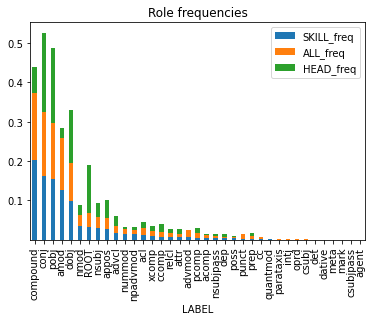

In [43]:
gen_stack([role_skills, role_all, head_skill_role], ['SKILL', 'ALL', 'HEAD'], my_title='Role frequencies')

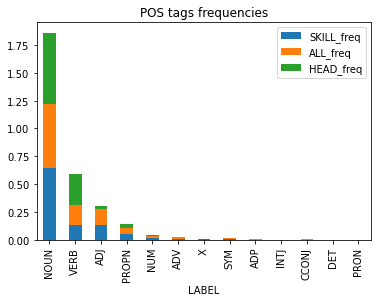

In [44]:
gen_stack([simple_pos_skills, simple_pos_all, head_skill_simple_pos], ['SKILL', 'ALL', 'HEAD'], my_title='POS tags frequencies')

As we can see, it is hard to identify any meaningful patterns here. We cannot find any roles or POS tags which appear disproprotionally in skills or skills heads. Let's move on to investigating the head words

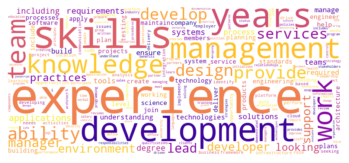

In [58]:
wc_head=gen_wordCloud(head_text)

In [59]:
with open('head_4k.svg', 'w') as f:
    f.write(wc_head.to_svg())

As we can see the words in the heads make sense, and they appear to be good predictors for future skills. Let's go one level down.

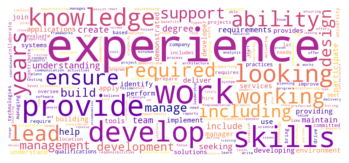

In [60]:
wc_h2=gen_wordCloud(head_head_text)

In [61]:
with open('head2_4k.svg', 'w') as f:
    f.write(wc_h2.to_svg())

These words may also be important predictors.

## Conclusions for Step 2: 
**The roles in the sentences and POS (part-of-speech) tags are not good predictors of skills appearance. However, certain words in the heads are good predictors. Thus, in the next steps we will explore the relationship further: we will explore the families of each skill and see whether any patterns can be fiund there.**